# **Seattle Micromobility: Collision Analysis**

## **Part 2**

This notebook continues the analysis of micromobility-related collisions in Seattle. 

The goal is to:
- Identify **spatiotemporal patterns** in micromobility-related collisions.
- Locate **collision hotspot** using clustering techniques.
- Examine the correlation between collisions and **infrastructure elements** (e.g., sidewalks, bike lanes).
- Explore how **geographic features** (slope) influence  collision risks.

## **Import Required Libraries**

In [249]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import matplotlib.animation as animation
import seaborn as sns
import contextily as ctx
from shapely.ops import nearest_points
import requests
from scipy.stats import gaussian_kde
import rioxarray as rxr

In [2]:
%matplotlib inline

## **Load cleaned data**

In [162]:
collision_file = "/home/jovyan/seattle-micromobility/data/processed/seattle_collisions.geojson"
bike_facilities_file = "/home/jovyan/seattle-micromobility/data/processed/seattle_bike_facilities.geojson"
multi_use_trails_file = "/home/jovyan/seattle-micromobility/data/processed/seattle_multi_use_trails.geojson"
sidewalks_file = "/home/jovyan/seattle-micromobility/data/processed/seattle_sidewalks.geojson"

collisions_gdf = gpd.read_file(collision_file)
bike_facilities_gdf = gpd.read_file(bike_facilities_file)
multi_use_trails_gdf = gpd.read_file(multi_use_trails_file)
sidewalks_gdf = gpd.read_file(sidewalks_file)

print(f"Collisions: {len(collisions_gdf)}")
print(f"Bike Facilities: {len(bike_facilities_gdf)}")
print(f"Multi-use Trails: {len(multi_use_trails_gdf)}")
print(f"Sidewalks: {len(sidewalks_gdf)}")

Collisions: 36334
Bike Facilities: 3540
Multi-use Trails: 203
Sidewalks: 46081


## **Retrieve Road Network from OpenStreetMap**

Use the `osmx` library to extract Seattle's **road network** from OpenStreetMap (OSM).

In [5]:
place_name = "Seattle, Washington, USA"
G = ox.graph_from_place(place_name, network_type="all")
edges = ox.graph_to_gdfs(G, nodes=False)

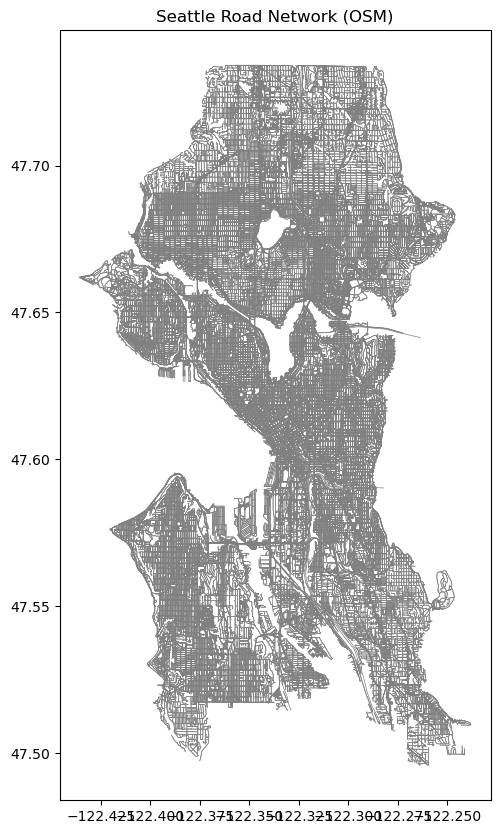

In [6]:
#Plot the road network

fig, ax = plt.subplots(figsize=(10,10))
edges.plot(ax=ax, color='gray', lw=0.5)
plt.title("Seattle Road Network (OSM)")
plt.show()

In [ ]:
# Save edges to GeoJSON
edges_path = "/home/jovyan/seattle-micromobility/data/processed/seattle_road_edges.geojson"
edges.to_file(edges_path, driver="GeoJSON")

In [7]:
road_file = "/home/jovyan/seattle-micromobility/data/processed/seattle_road_edges.geojson"
road_gdf = gpd.read_file(road_file)

Skipping field highway: unsupported OGR type: 5
Skipping field lanes: unsupported OGR type: 5
Skipping field maxspeed: unsupported OGR type: 5
Skipping field bridge: unsupported OGR type: 5
Skipping field name: unsupported OGR type: 5
Skipping field tunnel: unsupported OGR type: 5
Skipping field access: unsupported OGR type: 5
Skipping field service: unsupported OGR type: 5
Skipping field width: unsupported OGR type: 5


In [8]:
road_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [9]:
road_gdf

u            v  key  \
0          29445663    335444348    0   
1          29445663     29485641    0   
2          29447670  10791184628    0   
3          29447670   7010447296    0   
4          29449421   9567450119    0   
...             ...          ...  ...   
499320  12636775180  12636775181    0   
499321  12636775180  12636775168    0   
499322  12636775181   9451613074    0   
499323  12636775181   4829678980    0   
499324  12636775181  12636775180    0   

                                                    osmid  oneway     ref  \
0                                                 4634309    True  WA 520   
1                                               608025479    True     I 5   
2               [ 40416106, 4635028, 607798222, 4634847 ]    True    None   
3                      [ 40416108, 981053037, 143178398 ]    True  WA 520   
4                    [ 1052610031, 446010581, 143178399 ]    True  WA 520   
...                                                   ...     ...     ...   
499320                                         1364569600   False    None   
499321  [ 1364569600, 1364569604, 1364569598, 13645695...   False    None   
499322                                          490779501   False    None   
499323                                          490779501   False    None   
499324                                         1364569600   False    None   

       reversed      length junction est_width  \
0         False  636.023387     None      None   
1         False  545.156145     None      None   
2         False  375.451406     None      None   
3         False  475.837491     None      None   
4         False  715.929909     None      None   
...         ...         ...      ...       ...   
499320     True    2.015787     None      None   
499321    False   22.215531     None      None   
499322    False   10.330903     None      None   
499323     True    5.982863     None      None   
499324    False    2.015787     None      None   

                                                 geometry  
0       LINESTRING (-122.32263 47.63854, -122.32251 47...  
1       LINESTRING (-122.32263 47.63854, -122.32257 47...  
2       LINESTRING (-122.30891 47.64331, -122.30805 47...  
3       LINESTRING (-122.30891 47.64331, -122.30663 47...  
4       LINESTRING (-122.30916 47.64334, -122.30949 47...  
...                                                   ...  
499320  LINESTRING (-122.31786 47.65849, -122.31789 47...  
499321  LINESTRING (-122.31786 47.65849, -122.31783 47...  
499322  LINESTRING (-122.31789 47.65849, -122.31789 47...  
499323  LINESTRING (-122.31789 47.65849, -122.31789 47...  
499324  LINESTRING (-122.31789 47.65849, -122.31786 47...  

[499325 rows x 11 columns]

## **Exploratory Data Analysis (EDA)**

### **Basic dataset information**

In [163]:
pd.set_option("display.max_columns", None)

In [164]:
collisions_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 36334 entries, 0 to 36333
Data columns (total 37 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   STATUS                   36334 non-null  object        
 1   ADDRTYPE                 36334 non-null  object        
 2   INTKEY                   14745 non-null  float64       
 3   LOCATION                 36334 non-null  object        
 4   SEVERITYCODE             36334 non-null  object        
 5   SEVERITYDESC             36334 non-null  object        
 6   COLLISIONTYPE            27008 non-null  object        
 7   PERSONCOUNT              36334 non-null  int32         
 8   PEDCOUNT                 36334 non-null  int32         
 9   PEDCYLCOUNT              36334 non-null  int32         
 10  VEHCOUNT                 36334 non-null  int32         
 11  INJURIES                 36334 non-null  int32         
 12  SERIOUSINJURIES         

In [165]:
collisions_gdf.head()

STATUS      ADDRTYPE   INTKEY  \
0    Matched         Block      NaN   
1  Unmatched         Block      NaN   
2    Matched  Intersection  34329.0   
3  Unmatched         Block      NaN   
4    Matched  Intersection  30603.0   

                                            LOCATION SEVERITYCODE  \
0   19TH AVE E BETWEEN E THOMAS ST AND E HARRISON ST            1   
1    SUMMIT AVE BETWEEN E OLIVE ST AND E HOWELL W ST            0   
2                       SHAFFER AVE S AND S HOLLY ST            2   
3  EAST MARGINAL WAY S BETWEEN S MYRTLE ST AND EL...            1   
4                        28TH AVE S AND S JACKSON ST            1   

                     SEVERITYDESC COLLISIONTYPE  PERSONCOUNT  PEDCOUNT  \
0  Property Damage Only Collision    Parked Car            2         0   
1                         Unknown          None            2         0   
2                Injury Collision        Angles            6         0   
3  Property Damage Only Collision          None            1         0   
4  Property Damage Only Collision        Cycles            2         0   

   PEDCYLCOUNT  VEHCOUNT  INJURIES  SERIOUSINJURIES  FATALITIES    INCDATE  \
0            0         2         0                0           0 2023-03-02   
1            0         0         0                0           0 2024-05-26   
2            0         3         1                0           0 2023-02-10   
3            0         0         0                0           0 2024-04-18   
4            1         1         0                0           0 2023-07-10   

                INCDTTM                             JUNCTIONTYPE SDOT_COLCODE  \
0   3/2/2023 8:38:00 AM  Mid-Block (not related to intersection)           11   
1             5/26/2024  Mid-Block (not related to intersection)           11   
2  2/10/2023 3:55:00 PM   At Intersection (intersection related)           11   
3             4/18/2024  Mid-Block (not related to intersection)           14   
4  7/10/2023 8:01:00 PM   At Intersection (intersection related)           93   

                                        SDOT_COLDESC UNDERINFL   WEATHER  \
0  MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...         N  Overcast   
1  MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...      None      None   
2  MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...         N     Clear   
3       MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END      None      None   
4  MOTOR VEHICLE STRUCK MOTORIZED SCOOTER, FRONT ...         N     Clear   

  ROADCOND LIGHTCOND PEDROWNOTGRNT SPEEDING ST_COLCODE  \
0      Wet  Daylight          None     None         19   
1     None      None          None     None       None   
2      Dry  Daylight          None     None         10   
3     None      None          None     None       None   
4      Dry  Daylight          None     None          6   

                            ST_COLDESC  SEGLANEKEY  CROSSWALKKEY HITPARKEDCAR  \
0     One car entering parked position           0             0            N   
1                                 None           0             0            Y   
2                    Entering at angle           0             0            N   
3                                 None           0             0            N   
4  Pedalcyclist Strikes Moving Vehicle           0             0            N   

    SPDCASENO                        SOURCEDESC    ADDDTTM    MODDTTM  \
0  2023-58369   Police Traffic Collision Report 2023-07-11 2023-07-18   
1        None  Citizen Vehicle Collision Report 2024-05-29 2024-05-29   
2  2023-39444   Police Traffic Collision Report 2023-07-12 2023-07-18   
3        None  Citizen Vehicle Collision Report 2024-05-22 2024-05-22   
4   23-194663   Police Traffic Collision Report 2023-07-17 2024-04-16   

  SHAREDMICROMOBILITYDESC  YEAR                        geometry  
0                    None  2023  POINT (552046.428 5274440.465)  
1                    None  2024  POINT (550681.871 5273957.649)  
2                    None

### **Collision Severity Distribution**

In [166]:
# Standardize Fatal Collision labels
collisions_gdf["SEVERITYDESC"] = collisions_gdf["SEVERITYDESC"].replace(
    {"Fatal Collision": "Fatality Collision"}
)
severity_counts = collisions_gdf["SEVERITYDESC"].value_counts()
print(severity_counts)

SEVERITYDESC
Property Damage Only Collision    21194
Injury Collision                  10033
Unknown                            3911
Serious Injury Collision           1057
Fatality Collision                  139
Name: count, dtype: int64


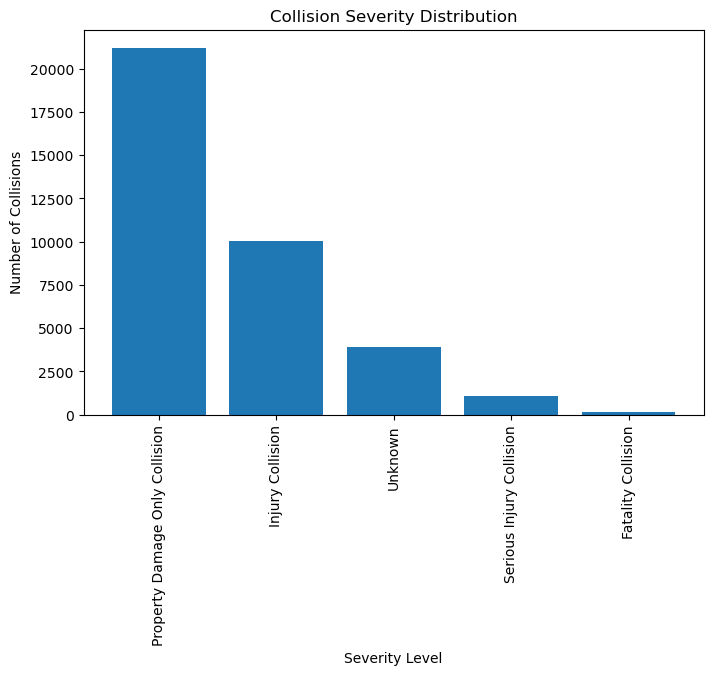

In [9]:
severity_counts = collisions_gdf['SEVERITYDESC'].value_counts()

plt.figure(figsize=(8,5))
plt.bar(severity_counts.index, severity_counts.values)
plt.xticks(rotation=90)
plt.title('Collision Severity Distribution')
plt.xlabel('Severity Level')
plt.ylabel('Number of Collisions')
plt.show()

### **Yearly Trends in Collisions**

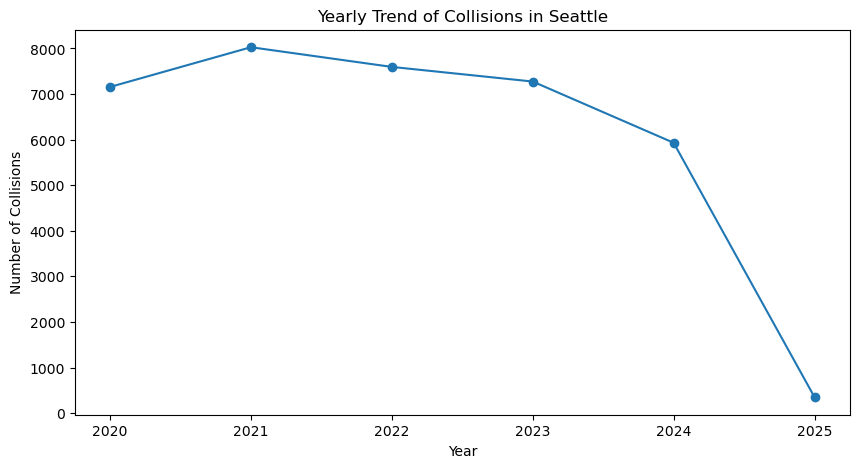

In [167]:
collision_by_year = collisions_gdf.groupby('YEAR').size()

plt.figure(figsize=(10,5))
plt.plot(collision_by_year.index, collision_by_year.values, marker='o')
plt.title('Yearly Trend of Collisions in Seattle')
plt.xlabel('Year')
plt.ylabel('Number of Collisions')
plt.show()

In [11]:
collision_by_year

YEAR
2020    7156
2021    8028
2022    7596
2023    7275
2024    5931
2025     348
dtype: int64

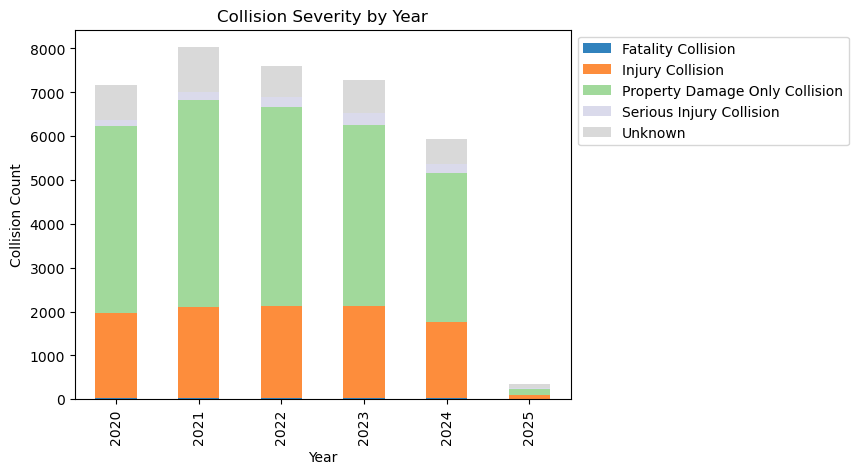

In [8]:
severity_by_year = collisions_gdf.groupby(["YEAR", "SEVERITYDESC"]).size().unstack()
severity_by_year.plot(kind="bar", stacked=True, colormap="tab20c")
plt.title("Collision Severity by Year")
plt.xlabel("Year")
plt.ylabel("Collision Count")
plt.legend(bbox_to_anchor=(1,1))
plt.show()

### **Collisions by Road User Type**

In [168]:
# Standardize shared micromobility labels
collisions_gdf["SHAREDMICROMOBILITYDESC"] = collisions_gdf["SHAREDMICROMOBILITYDESC"].replace({
    "Unknown": "Not Reported",  
    "No, Shared Micro Mobility was not involved": "Not Involved",
    "Yes, Shared Micro Mobility was involved": "Involved"
})

In [169]:
collision_counts = {
    "Pedestrians": (collisions_gdf['PEDCOUNT'] >0).sum(),
    "Cyclists": (collisions_gdf['PEDCYLCOUNT']>0).sum(),
    "Vehicles": (collisions_gdf['VEHCOUNT']>0).sum()
}
user_types = list(collision_counts.keys())
collision_values = list(collision_counts.values())

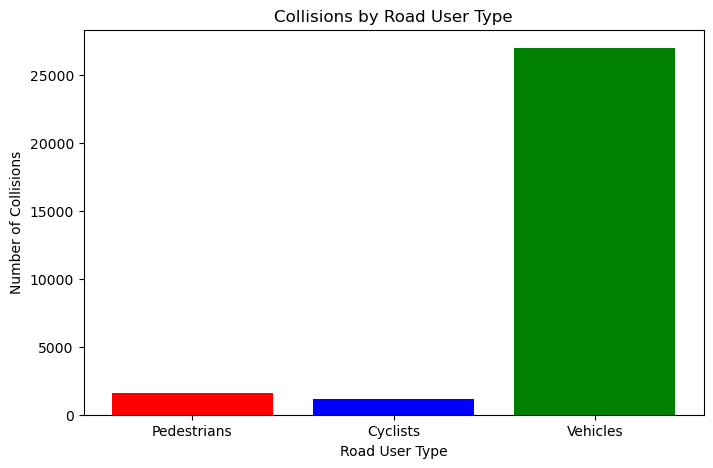

In [170]:
plt.figure(figsize=(8,5))
plt.bar(user_types,collision_values, color=['red','blue','green'])
plt.title('Collisions by Road User Type')
plt.xlabel('Road User Type')
plt.ylabel('Number of Collisions')
plt.show()

In [16]:
collision_counts

{'Pedestrians': np.int64(1608),
 'Cyclists': np.int64(1168),
 'Vehicles': np.int64(26984)}

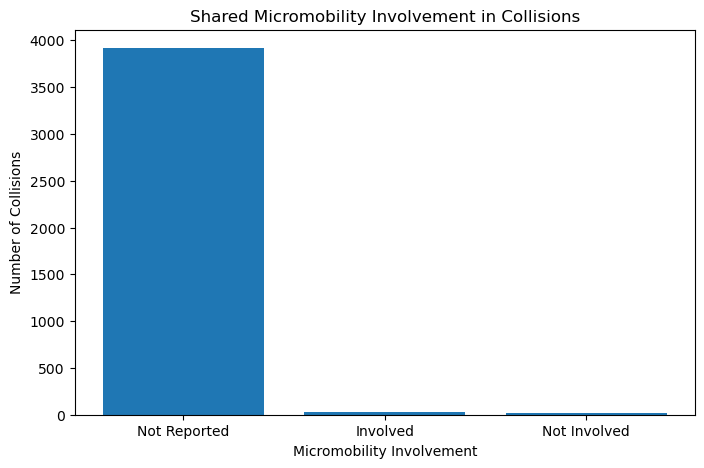

In [171]:
shared_micromobility_counts = collisions_gdf["SHAREDMICROMOBILITYDESC"].value_counts()

plt.figure(figsize=(8, 5))
plt.bar(shared_micromobility_counts.index, shared_micromobility_counts.values)

plt.title("Shared Micromobility Involvement in Collisions")
plt.xlabel("Micromobility Involvement")
plt.ylabel("Number of Collisions")

plt.show()

In [18]:
shared_micromobility_counts

SHAREDMICROMOBILITYDESC
Not Reported    3918
Involved          31
Not Involved      17
Name: count, dtype: int64

## **Micromobility users Collisions**

In [172]:
#Filter collisions where PEDCOUNT or PEDCYLCOUNT > 0
micromobility_collisions = collisions_gdf[(collisions_gdf['PEDCOUNT'] > 0)|(collisions_gdf['PEDCYLCOUNT'] > 0)].copy()

print(f"Total Collisions Involving Micromobility Users: {len(micromobility_collisions)}")
micromobility_collisions.info()

Total Collisions Involving Micromobility Users: 2765
<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 2765 entries, 4 to 36257
Data columns (total 37 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   STATUS                   2765 non-null   object        
 1   ADDRTYPE                 2765 non-null   object        
 2   INTKEY                   1800 non-null   float64       
 3   LOCATION                 2765 non-null   object        
 4   SEVERITYCODE             2765 non-null   object        
 5   SEVERITYDESC             2765 non-null   object        
 6   COLLISIONTYPE            2765 non-null   object        
 7   PERSONCOUNT              2765 non-null   int32         
 8   PEDCOUNT                 2765 non-null   int32         
 9   PEDCYLCOUNT              2765 non-null   int32         
 10  VEHCOUNT                 2765 non-null   int32         
 11  INJURIES                 2765 non-null

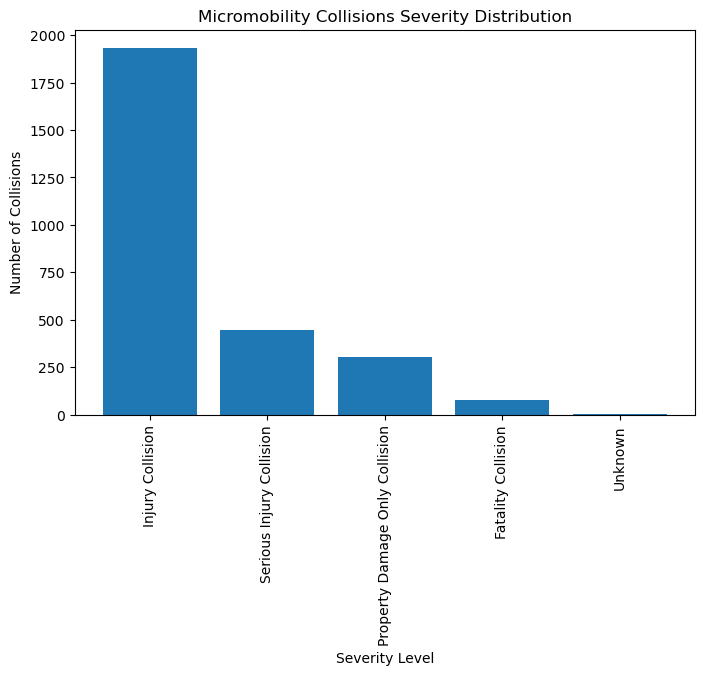

In [10]:
severity_counts = micromobility_collisions['SEVERITYDESC'].value_counts()

plt.figure(figsize=(8,5))
plt.bar(severity_counts.index, severity_counts.values)
plt.xticks(rotation=90)
plt.title('Micromobility Collisions Severity Distribution')
plt.xlabel('Severity Level')
plt.ylabel('Number of Collisions')
plt.show()

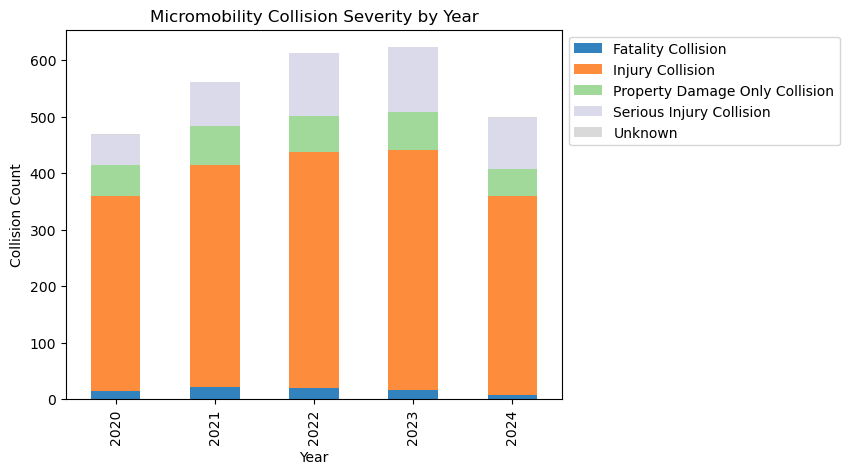

In [11]:
severity_by_year = micromobility_collisions.groupby(["YEAR", "SEVERITYDESC"]).size().unstack()
severity_by_year.plot(kind="bar", stacked=True, colormap="tab20c")
plt.title("Micromobility Collision Severity by Year")
plt.xlabel("Year")
plt.ylabel("Collision Count")
plt.legend(bbox_to_anchor=(1,1))
plt.show()

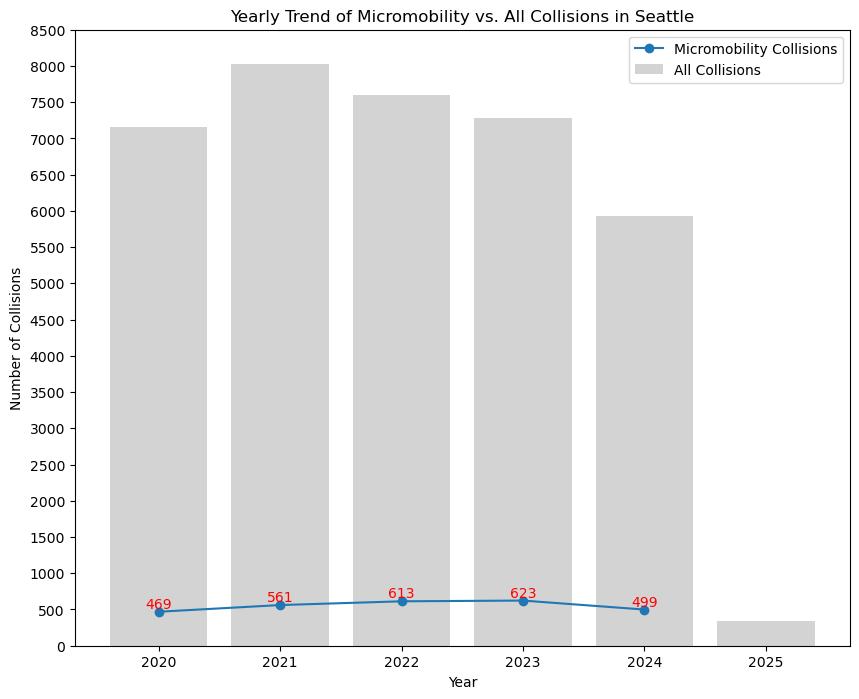

In [22]:
micro_collision_by_year = micromobility_collisions.groupby('YEAR').size()

plt.figure(figsize=(10,8))
plt.bar(collision_by_year.index, collision_by_year.values, color="lightgray", label="All Collisions")
plt.plot(micro_collision_by_year.index, micro_collision_by_year.values, marker='o', label="Micromobility Collisions")
for year, value in zip(micro_collision_by_year.index, micro_collision_by_year.values):
    plt.text(year, value + 50, str(value), ha="center", fontsize=10, color="red") 
y_max = max(collision_by_year.max(), micro_collision_by_year.max())  # Get max value
plt.yticks(np.arange(0, y_max + 500, 500))
plt.title('Yearly Trend of Micromobility vs. All Collisions in Seattle')
plt.xlabel('Year')
plt.ylabel('Number of Collisions')
plt.legend()
plt.show()

### **Spatiotemporal Analysis**

#### **Time-Series**

**Time of Day**

In [173]:
collisions_gdf["INCDTTM"] = pd.to_datetime(
    collisions_gdf["INCDTTM"], errors="coerce"
)

In [174]:
collisions_gdf["Hour"] = collisions_gdf["INCDTTM"].dt.hour
collisions_gdf["DayOfWeek"] = collisions_gdf["INCDATE"].dt.day_name()
collisions_gdf["Month"] = collisions_gdf["INCDATE"].dt.month_name()

hourly_counts = collisions_gdf.dropna(subset=["Hour"])["Hour"].value_counts().sort_index()

day_counts = collisions_gdf["DayOfWeek"].value_counts().reindex(
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
)
month_counts = collisions_gdf["Month"].value_counts().reindex([
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
])

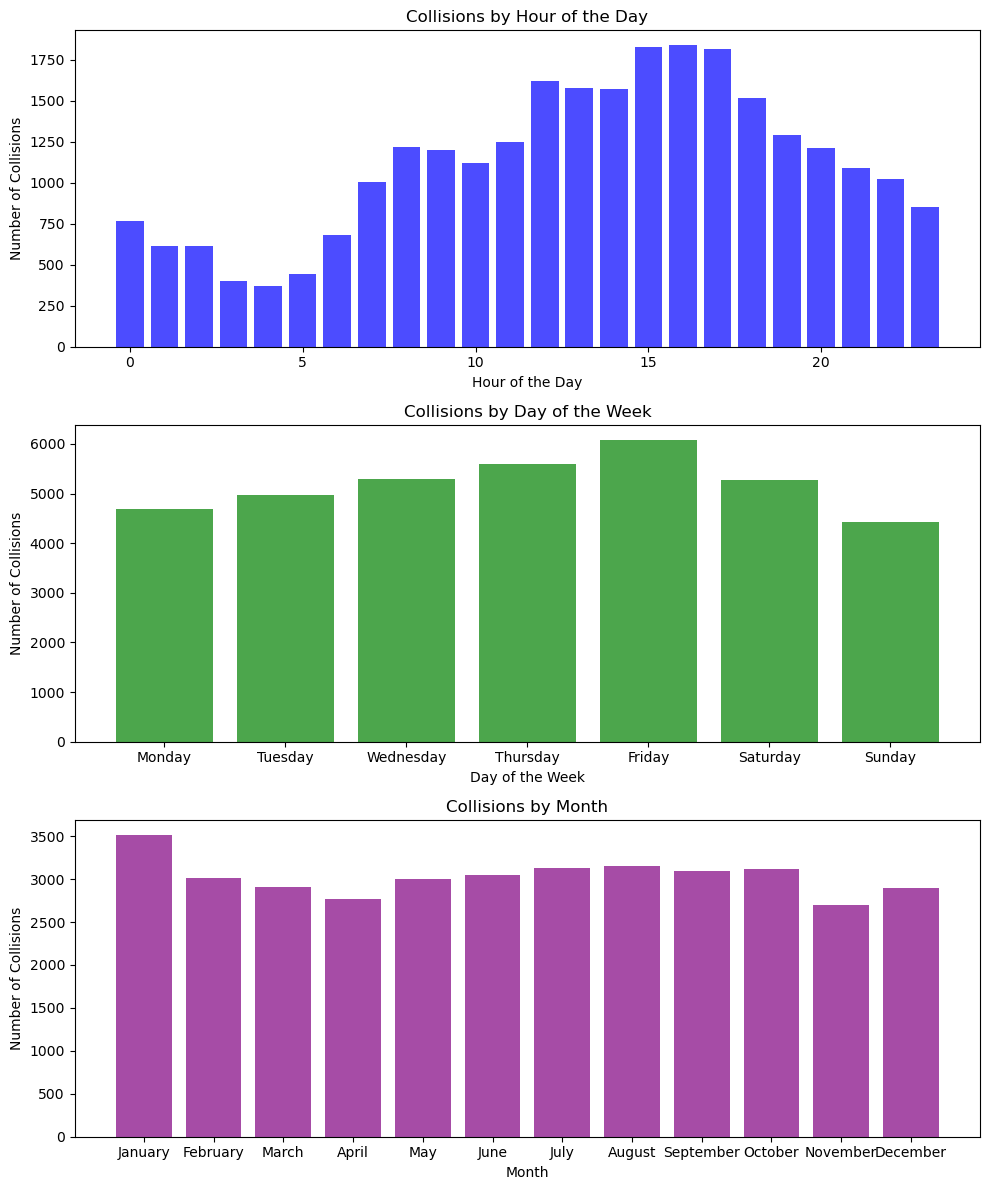

In [175]:
fig, axes = plt.subplots(3, 1, figsize=(10, 12))

axes[0].bar(hourly_counts.index, hourly_counts.values, color="blue", alpha=0.7)
axes[0].set_title("Collisions by Hour of the Day")
axes[0].set_xlabel("Hour of the Day")
axes[0].set_ylabel("Number of Collisions")

axes[1].bar(day_counts.index, day_counts.values, color="green", alpha=0.7)
axes[1].set_title("Collisions by Day of the Week")
axes[1].set_xlabel("Day of the Week")
axes[1].set_ylabel("Number of Collisions")

axes[2].bar(month_counts.index, month_counts.values, color="purple", alpha=0.7)
axes[2].set_title("Collisions by Month")
axes[2].set_xlabel("Month")
axes[2].set_ylabel("Number of Collisions")

plt.tight_layout()
plt.show()

In [176]:
micromobility_collisions["INCDTTM"] = pd.to_datetime(
    micromobility_collisions["INCDTTM"], format="mixed", errors="coerce"
)

In [177]:
micromobility_collisions["Hour"] = micromobility_collisions["INCDTTM"].dt.hour
micromobility_collisions["DayOfWeek"] = micromobility_collisions["INCDATE"].dt.day_name()
micromobility_collisions["Month"] = micromobility_collisions["INCDATE"].dt.month_name()

hourly_counts = micromobility_collisions["Hour"].value_counts().sort_index()
day_counts = micromobility_collisions["DayOfWeek"].value_counts().reindex(
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
)
month_counts = micromobility_collisions["Month"].value_counts().reindex([
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
])

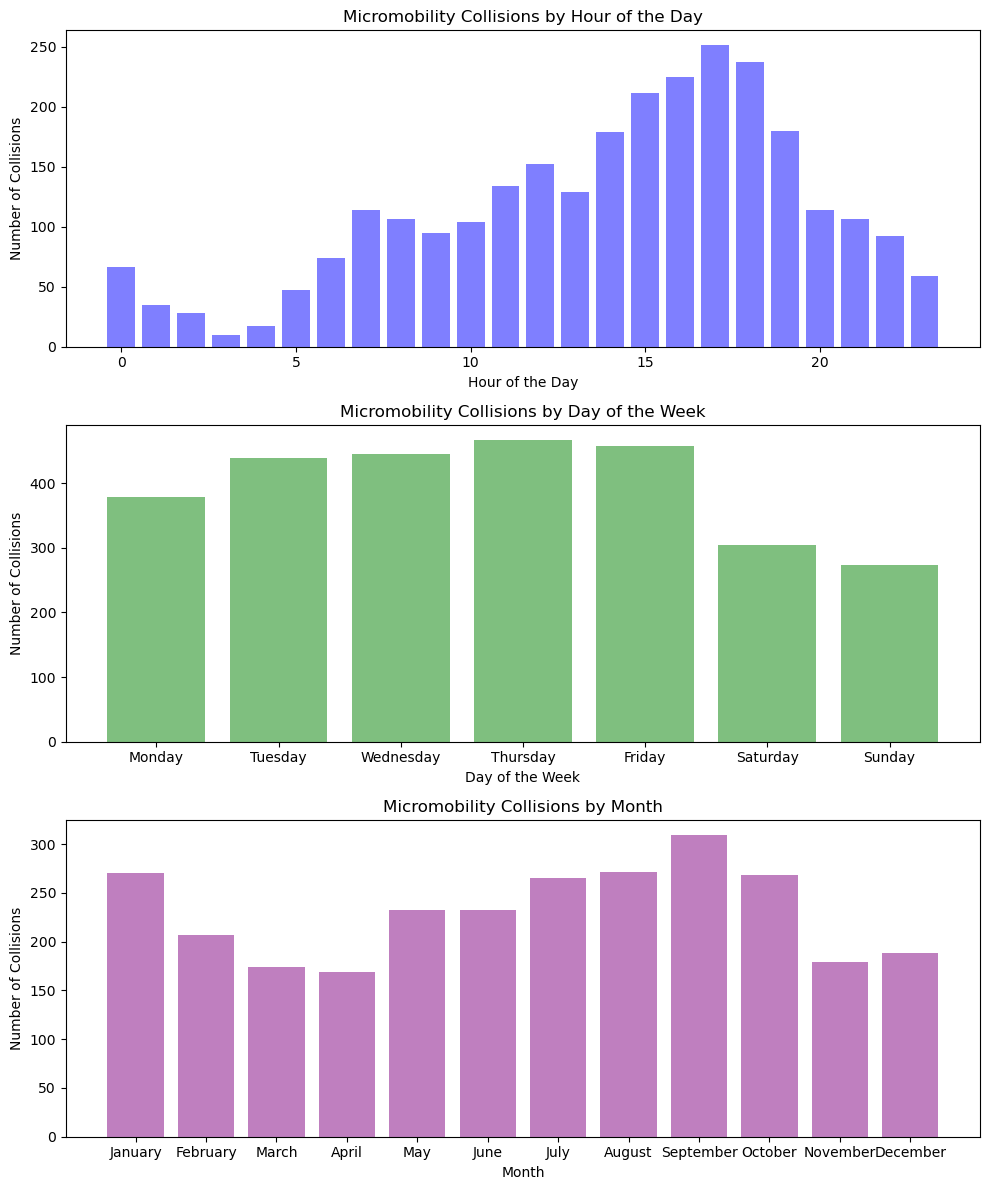

In [178]:
fig, axes = plt.subplots(3, 1, figsize=(10, 12))

axes[0].bar(hourly_counts.index, hourly_counts.values, color="blue", alpha=0.5)
axes[0].set_title("Micromobility Collisions by Hour of the Day")
axes[0].set_xlabel("Hour of the Day")
axes[0].set_ylabel("Number of Collisions")

axes[1].bar(day_counts.index, day_counts.values, color="green", alpha=0.5)
axes[1].set_title("Micromobility Collisions by Day of the Week")
axes[1].set_xlabel("Day of the Week")
axes[1].set_ylabel("Number of Collisions")

axes[2].bar(month_counts.index, month_counts.values, color="purple", alpha=0.5)
axes[2].set_title("Micromobility Collisions by Month")
axes[2].set_xlabel("Month")
axes[2].set_ylabel("Number of Collisions")

plt.tight_layout()
plt.show()

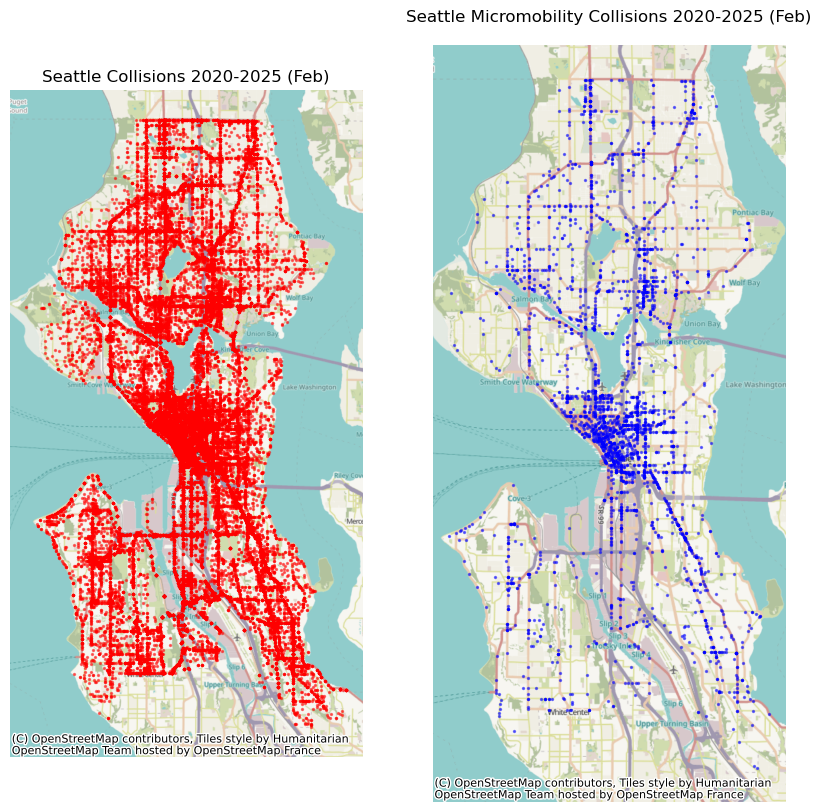

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))

collisions_gdf.to_crs(epsg=3857).plot(
    ax=ax[0], 
    markersize=2, 
    alpha=0.5, 
    color="red"
)

ctx.add_basemap(ax[0], crs=collisions_gdf.to_crs(epsg=3857).crs)

ax[0].set_title("Seattle Collisions 2020-2025 (Feb)")
ax[0].set_axis_off()

micromobility_collisions.to_crs(epsg=3857).plot(
    ax=ax[1], 
    markersize=2, 
    alpha=0.5, 
    color="blue"
)

ctx.add_basemap(ax[1], crs=collisions_gdf.to_crs(epsg=3857).crs)

ax[1].set_title("Seattle Micromobility Collisions 2020-2025 (Feb)")
ax[1].set_axis_off()
plt.show()

/opt/conda/lib/python3.11/site-packages/contextily/tile.py:645: UserWarning: The inferred zoom level of 27 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)


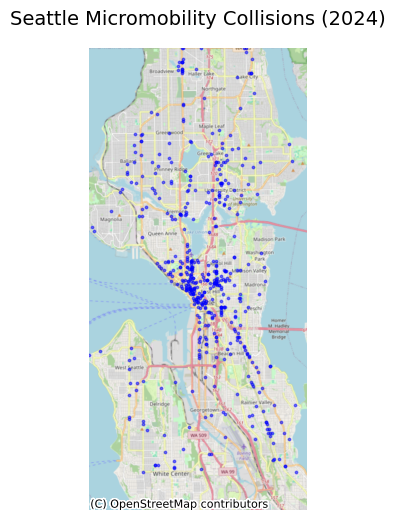

In [52]:

xmin, ymin, xmax, ymax = micromobility_collisions.total_bounds


years = sorted(micromobility_collisions["YEAR"].dropna().unique())

fig, ax = plt.subplots(figsize=(10, 6))


plt.draw()

def update_all(year):

    ctx.add_basemap(ax, crs=micromobility_collisions.crs, source=ctx.providers.OpenStreetMap.Mapnik)  
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])

    for coll in ax.collections:
        coll.remove()
    
    yearly_collisions = micromobility_collisions[micromobility_collisions["YEAR"] == year]

    if not yearly_collisions.empty:
        yearly_collisions.plot(ax=ax, markersize=3, alpha=0.5, color="blue")

    ax.set_title(f"Seattle Micromobility Collisions ({year})", fontsize=14)
    ax.set_axis_off()

ani_all = animation.FuncAnimation(fig, update_all, frames=years, repeat=True, interval=1000)

ani_all.save("seattle_micro_collisions.gif", writer="pillow", dpi=100)

plt.show()

## **Proximity Analysis**

### **Collisions Near each existing infrasturcture**

In [102]:
base_crs = "EPSG:32610"
collisions_gdf = collisions_gdf.to_crs(base_crs)
micromobility_collisions = micromobility_collisions.to_crs(base_crs)

In [60]:
# Collisions within 50 m for existing bike facilities 
collisions_near_bikes = gpd.sjoin_nearest(
    micromobility_collisions,
    bike_facilities_gdf,
    how='left',
    max_distance=50,  
    distance_col='dist_to_bike' 
)
bike_collisions_within_50m = collisions_near_bikes.dropna(subset=['dist_to_bike'])
print(f"Micromobility Collisions truly within 50 meters of existing bike facilities:")
print(f"{bike_collisions_within_50m.shape[0]} about {bike_collisions_within_50m.shape[0]/len(micromobility_collisions)*100:.2f} %")

Micromobility Collisions truly within 50 meters of existing bike facilities:
1648 about 59.60 %


In [62]:
# Collisions within 50 m for multi-use trails
collisions_near_multitrails = gpd.sjoin_nearest(
    micromobility_collisions,
    multi_use_trails_gdf,
    how='left',
    max_distance=50, 
    distance_col='dist_to_trails' 
)
trail_collisions_within_50m = collisions_near_multitrails.dropna(subset=['dist_to_trails'])
print(f"Micromobility Collisions truly within 50 meters of multi-use trails:")
print(f"{trail_collisions_within_50m.shape[0]} about {trail_collisions_within_50m.shape[0]/len(micromobility_collisions)*100:.2f} %")

Micromobility Collisions truly within 50 meters of multi-use trails:
158 about 5.71 %


In [63]:
# Collisions within 50 m for sidewalks 
collisions_near_sidewalks = gpd.sjoin_nearest(
    micromobility_collisions,
    sidewalks_gdf,
    how='left',
    max_distance=50, 
    distance_col='dist_to_sidewalks' 
)
sidewalk_collisions_within_50m = collisions_near_sidewalks.dropna(subset=['dist_to_sidewalks'])
sidewalk_collisions_within_50m = collisions_within_50m.drop_duplicates(subset=['INCDATE', 'LOCATION'])

print(f"Micromobility Collisions truly within 50 meters of sidewalks:")
print(f"{sidewalk_collisions_within_50m.shape[0]} about {sidewalk_collisions_within_50m.shape[0]/len(micromobility_collisions)*100:.2f} %")

Micromobility Collisions truly within 50 meters of sidewalks:
2758 about 99.75 %


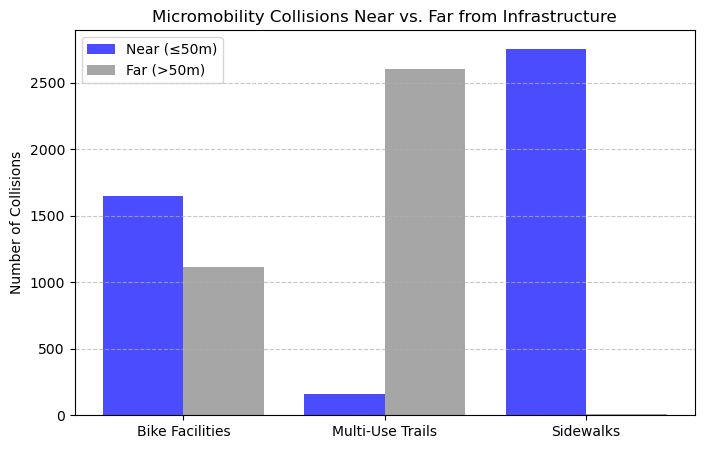

In [64]:
categories = ["Bike Facilities", "Multi-Use Trails", "Sidewalks"]
near_counts = [bike_collisions_within_50m.shape[0], trail_collisions_within_50m.shape[0], sidewalk_collisions_within_50m.shape[0]]
far_counts = [len(micromobility_collisions)-bike_collisions_within_50m.shape[0] , len(micromobility_collisions)-trail_collisions_within_50m.shape[0], len(micromobility_collisions)-sidewalk_collisions_within_50m.shape[0]]

x = np.arange(len(categories))

plt.figure(figsize=(8, 5))
plt.bar(x, near_counts, width=0.4, label="Near (≤50m)", color="blue", alpha=0.7)
plt.bar(x + 0.4, far_counts, width=0.4, label="Far (>50m)", color="gray", alpha=0.7)

plt.xticks(x + 0.2, categories)
plt.ylabel("Number of Collisions")
plt.title("Micromobility Collisions Near vs. Far from Infrastructure")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

In [83]:
def plot_collisions_with_buffer(collisions, infrastructure, infra_name, buffer_distance=50, infra_color="blue"):


    infra_buffer = infrastructure.copy()
    infra_buffer["geometry"] = infra_buffer.geometry.buffer(buffer_distance)

    collisions_near = gpd.sjoin_nearest(collisions, infrastructure, how="left", max_distance=buffer_distance)
    collisions_within_buffer = collisions_near.dropna(subset=["index_right"])

    fig, ax = plt.subplots(figsize=(15, 8))

    infra_buffer.plot(ax=ax, color=infra_color, alpha=0.3, linestyle="dashed", label=f"{infra_name} Buffer ({buffer_distance}m)")

    collisions_within_buffer.plot(ax=ax, markersize=4, color="red", alpha=1, label="Collisions Near Infrastructure")

    collisions.plot(ax=ax, markersize=2, color="gray", alpha=0.4, label="Collisions Far from Infrastructure")

    ctx.add_basemap(ax, crs=collisions.crs, source=ctx.providers.OpenStreetMap.Mapnik)

    ax.legend(bbox_to_anchor=(1,1))

    ax.set_title(f"Micromobility Collisions Near {infra_name}")
    ax.set_axis_off()

    plt.show()


/tmp/ipykernel_197/2119026212.py:20: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(bbox_to_anchor=(1,1))


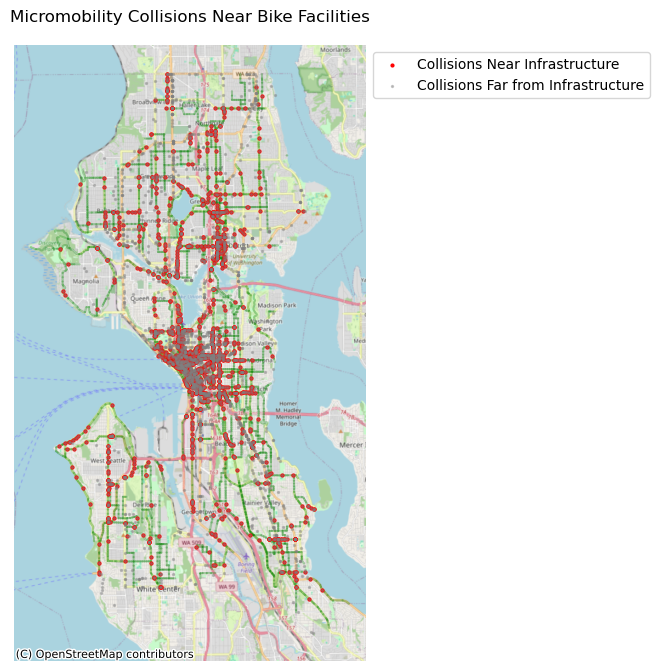

/tmp/ipykernel_197/2119026212.py:20: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(bbox_to_anchor=(1,1))


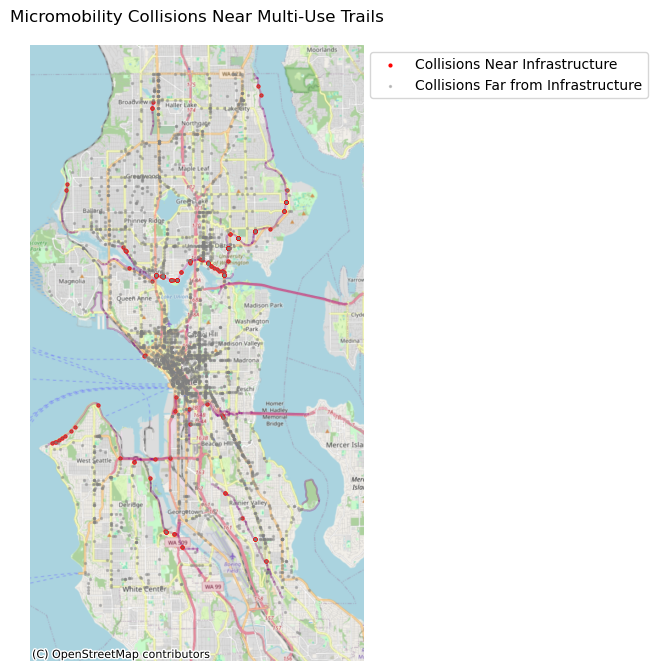

/tmp/ipykernel_197/2119026212.py:20: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(bbox_to_anchor=(1,1))


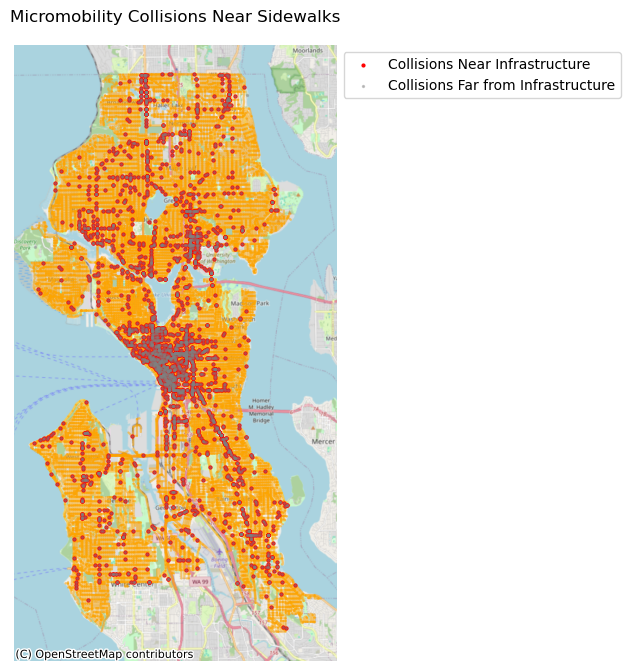

In [84]:
plot_collisions_with_buffer(micromobility_collisions, bike_facilities_gdf, "Bike Facilities", buffer_distance=50, infra_color="green")
plot_collisions_with_buffer(micromobility_collisions, multi_use_trails_gdf, "Multi-Use Trails", buffer_distance=50, infra_color="purple")
plot_collisions_with_buffer(micromobility_collisions, sidewalks_gdf, "Sidewalks", buffer_distance=50, infra_color="orange")

## **Hotspot of Collisions**

### **Use Kernel Density Estimation (KDE)**

Map Collisions hotspots that will identify high-risk areas.

In [200]:
neighborhoods_url = "https://services.arcgis.com/ZOyb2t4B0UYuYNYH/arcgis/rest/services/nma_nhoods_sub/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson"

In [234]:
neighborhoods_gdf = gpd.read_file(neighborhoods_url)

In [235]:
neighborhoods_gdf = neighborhoods_gdf.to_crs(base_crs)

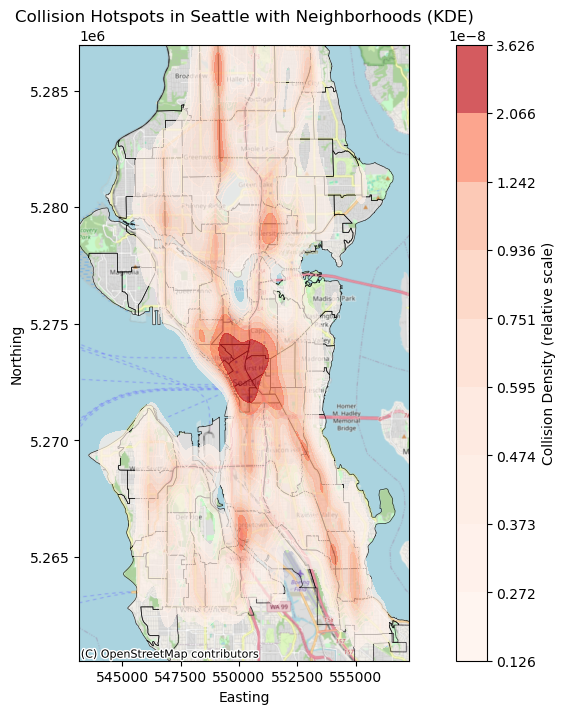

In [182]:
coords = np.array([(geom.x, geom.y) for geom in collisions_gdf.geometry if geom is not None])
x, y = coords[:, 0], coords[:, 1]
fig, ax = plt.subplots(figsize=(12, 8))
# Plot neighborhood boundaries
neighborhoods_gdf.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.5, alpha=0.8)

# Add KDE with contours for colorbar
kde = sns.kdeplot(
    x=x, y=y, cmap="Reds", fill=True, bw_adjust=0.5, alpha=0.7, ax=ax,
    levels=10  # Add contour levels for colorbar
)
# Add colorbar using the contour levels
plt.colorbar(ax.collections[-1], ax=ax, label='Collision Density (relative scale)')

# Set extent to match collision data
ax.set_xlim(collisions_gdf.total_bounds[0], collisions_gdf.total_bounds[2])  # minx to maxx
ax.set_ylim(collisions_gdf.total_bounds[1], collisions_gdf.total_bounds[3])  # miny to maxy

plt.title("Collision Hotspots in Seattle with Neighborhoods (KDE)")
plt.xlabel("Easting")
plt.ylabel("Northing")
ctx.add_basemap(ax, crs=base_crs, source=ctx.providers.OpenStreetMap.Mapnik)

plt.show()

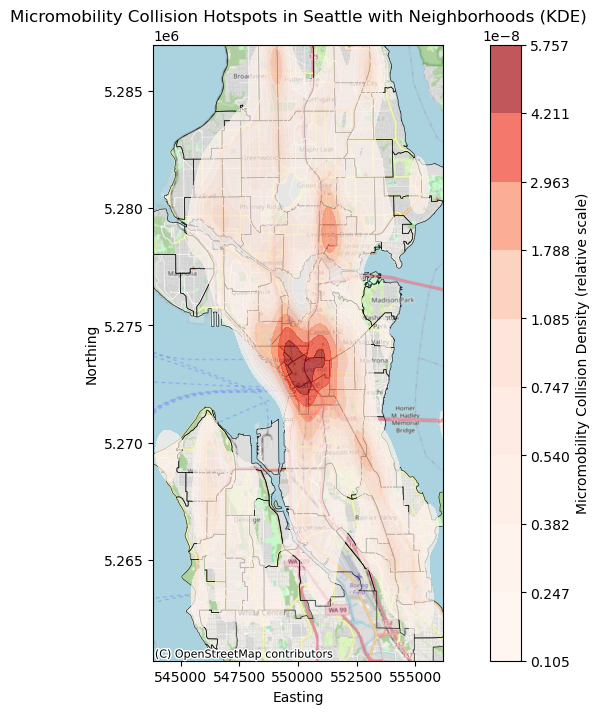

In [185]:
coords = np.array([(geom.x, geom.y) for geom in micromobility_collisions.geometry if geom is not None])
x, y = coords[:, 0], coords[:, 1]
fig, ax = plt.subplots(figsize=(12, 8))
# Plot neighborhood boundaries
neighborhoods_gdf.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.5, alpha=0.8)

# Add KDE with contours for colorbar
kde = sns.kdeplot(
    x=x, y=y, cmap="Reds", fill=True, bw_adjust=0.5, alpha=0.7, ax=ax,
    levels=10  # Add contour levels for colorbar
)
# Add colorbar using the contour levels
plt.colorbar(ax.collections[-1], ax=ax, label='Micromobility Collision Density (relative scale)')

# Set extent to match collision data
ax.set_xlim(micromobility_collisions.total_bounds[0], micromobility_collisions.total_bounds[2])  # minx to maxx
ax.set_ylim(micromobility_collisions.total_bounds[1], micromobility_collisions.total_bounds[3])  # miny to maxy

plt.title("Micromobility Collision Hotspots in Seattle with Neighborhoods (KDE)")
plt.xlabel("Easting")
plt.ylabel("Northing")
ctx.add_basemap(ax, crs=base_crs, source=ctx.providers.OpenStreetMap.Mapnik)

plt.show()

In [236]:
api_url = "https://services.arcgis.com/ZOyb2t4B0UYuYNYH/arcgis/rest/services/hh_population_types_Neighborhoods/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson"

population_gdf = gpd.read_file(api_url)

In [237]:
neighborhoods_gdf

OBJECTID               L_HOOD               S_HOOD  \
0         27              Ballard        Loyal Heights   
1         28              Ballard              Ballard   
2         29              Ballard     Whittier Heights   
3         30              Ballard        West Woodland   
4         31        North Central        Phinney Ridge   
..       ...                  ...                  ...   
89       119              Ballard          Sunset Hill   
90       121  University District  University District   
91       123  University District   University Heights   
92       124             Downtown       Denny Triangle   
93       126     Greater Duwamish  Industrial District   

             S_HOOD_ALT_NAMES   Shape__Area  Shape__Length  \
0                        None  2.132066e+07   18831.009596   
1                       Adams  2.255213e+07   29926.339300   
2                        None  1.419569e+07   15934.439266   
3                        None  2.219937e+07   21789.651087   
4               Woodland Park  3.212312e+07   27120.785938   
..                        ...           ...            ...   
89  Golden Gardens, Shilshole  2.433562e+07   29416.730063   
90                       None  1.368625e+07   21581.645979   
91                 Cowen Park  1.037575e+07   15163.906910   
92              Denny Regrade  5.128172e+06   10574.177983   
93                       None  6.243413e+07   88995.756984   

                                             geometry  
0   POLYGON ((546813.024 5280469.219, 546785.079 5...  
1   POLYGON ((546828.773 5279609.276, 546830.042 5...  
2   POLYGON ((546813.024 5280469.219, 546799.156 5...  
3   POLYGON ((546813.024 5280469.219, 546832.288 5...  
4   POLYGON ((549002.186 5279274.371, 548885.038 5...  
..                                                ...  
89  POLYGON ((544859.986 5282872.829, 544865.998 5...  
90  POLYGON ((552266.214 5279631.909, 552353.949 5...  
91  POLYGON ((551735.39 5280132.473, 551735.676 52...  
92  POLYGON ((549796.491 5273464.306, 549660.747 5...  
93  MULTIPOLYGON (((549040.45 5267526.646, 549043....  

[94 rows x 7 columns]

In [238]:
population_gdf

OBJECTID               NEIGH_NAME NEIGH_TYPE            NEIGH_SUB_TYPE  \
0          1      University District        CRA                 Northeast   
1          2           Ravenna/Bryant        CRA                 Northeast   
2          3      Wedgwood/View Ridge        CRA                 Northeast   
3          4   Laurelhurst/Sand Point        CRA                 Northeast   
4          5     Northgate/Maple Leaf        CRA                     North   
..       ...                      ...        ...                       ...   
87        88      University District       UCUV              Urban Center   
88        89                   Uptown       UCUV              Urban Center   
89        90                 Downtown       UCUV              Urban Center   
90        91  First Hill/Capitol Hill       UCUV              Urban Center   
91        92         Greater Duwamish       UCUV  Manufacturing Industrial   

   ACS_VINTAGE  TOTAL_HOUSEHOLDS  FAMILY_HOUSEHOLDS  NONFAMILY_HOUSEHOLDS  \
0         5Y23              6737               1253                  5484   
1         5Y23             10754               5829                  4925   
2         5Y23              6978               4742                  2236   
3         5Y23              4452               3029                  1423   
4         5Y23              7832               3955                  3877   
..         ...               ...                ...                   ...   
87        5Y23             10053               1687                  8366   
88        5Y23              8666               1881                  6785   
89        5Y23             27067               6535                 20532   
90        5Y23             32931               5544                 27387   
91        5Y23               322                 76                   246   

    NONFAMILY_HH_ALONE  NONFAMILY_HH_ROOMATES  FAMILY_HH_OWN_CHILD  \
0                 3617                   1867                  456   
1                 3091                   1834                 2695   
2                 1569                    667                 2034   
3                 1043                    380                 1627   
4                 2673                   1204                 1653   
..                 ...                    ...                  ...   
87                5467                   2899                  417   
88                5644                   1141                  166   
89               16700                   3832                  712   
90               21175                   6212                  888   
91                 184                     62                   24   

    MARRY_COUPLE_HH_OWN_CHILD  MALE_HH_OWN_CHILD  FEMALE_HH_OWN_CHILD  \
0                         336                 35                   85   
1                        2330                 83                  282   
2                        1857                 57                  120   
3                        1326                 72                  229   
4                         979                231                  443   
..                        ...                ...                  ...   
87                        188                 42                  187   
88                        166                  0                    0   
89                        374                104                  234   
90                        585                 72                  231   
91                         12                  5                    7   

    MARRIED_PARTNER_HH_NO_CHILD  SINGLE_PARENT_HH  OTHER_FAMILY_HH  \
0                           432               120              365   
1                          2818               365              316   
2                          2475               177              233   
3                          1337               301               65   
4                          1850               674              452   
..  

In [239]:
neigh_col = 'S_HOOD'
neighborhoods_gdf = neighborhoods_gdf.drop_duplicates(subset=[neigh_col], keep='first')
print("After deduplication, neighborhoods_gdf shape:", neighborhoods_gdf.shape)

After deduplication, neighborhoods_gdf shape: (94, 7)


In [240]:
neigh_unique = set(neighborhoods_gdf[neigh_col].dropna().unique())
pop_unique = set(population_gdf['NEIGH_NAME'].dropna().unique())

In [241]:
def find_match(s_hood, l_hood, pop_names):
    s_hood_lower = s_hood.lower()
    l_hood_lower = l_hood.lower()
    for pop_name in pop_names:
        pop_lower = pop_name.lower()
        if s_hood_lower in pop_lower or pop_lower in s_hood_lower:
            return pop_name
        if l_hood_lower in pop_lower or pop_lower in l_hood_lower:
            return pop_name
    manual_map = {
        'West Woodland': 'Ballard',
        'Whittier Heights': 'Ballard',
        'Sunset Hill': 'Ballard',
        'Denny Triangle': 'Downtown',
        'Pike-Market': 'Downtown',
        'Central Business District': 'Downtown',
        'Yesler Terrace': 'Downtown',
        'Pioneer Square': 'Downtown',
        'University Heights': 'University District',
        'University of Washington': 'University District',
        'Broadway': 'Capitol Hill',
        'Stevens': 'Capitol Hill',
        'Montlake': 'Capitol Hill',
        'Industrial District': 'Greater Duwamish',
        'Harbor Island': 'Greater Duwamish',
        'Bryant': 'Ravenna/Bryant',
        'Wedgwood': 'Wedgwood/View Ridge',
        'Windermere': 'Wedgwood/View Ridge',
        'Laurelhurst': 'Laurelhurst/Sand Point',
        'Phinney Ridge': 'Greenwood/Phinney Ridge',
        'Lower Queen Anne': 'Queen Anne',
        'North Queen Anne': 'Queen Anne',
        'East Queen Anne': 'Queen Anne',
        'West Queen Anne': 'Queen Anne',
        'Westlake': 'Cascade/Eastlake',
        'Lawton Park': 'Magnolia',
        'Briarcliff': 'Magnolia',
        'Southeast Magnolia': 'Magnolia',
        'Madrona': 'Madrona/Leschi',
        'Harrison/Denny-Blaine': 'Madrona/Leschi',
        'Minor': 'Central Area/Squire Park',
        'Mann': 'Central Area/Squire Park',
        'Atlantic': 'Central Area/Squire Park',
        'Seaview': 'West Seattle Junction',
        'Gatewood': 'West Seattle Junction',
        'North Admiral': 'West Seattle Junction',
        'Fairmount Park': 'West Seattle Junction',
        'Mid-Beacon Hill': 'Beacon Hill',
        'Holly Park': 'South Beacon Hill/NewHolly',
        'Brighton': 'Rainier Beach',
        'Dunlap': 'Rainier Beach',
        'Rainier View': 'Rainier Beach',
        'Mount Baker': 'Mt. Baker/North Rainier',
        'South Delridge': 'Roxhill/Westwood',
        'Victory Heights': 'Lake City',
        'Matthews Beach': 'Lake City',
        'Meadowbrook': 'Lake City',
        'Broadview': 'Broadview/Bitter Lake',
        'Pinehurst': 'Northgate'
    }
    return manual_map.get(s_hood)

In [242]:
s_hood_to_pop = {}
for idx, row in neighborhoods_gdf.iterrows():
    s_hood = row[neigh_col]
    l_hood = row['L_HOOD']
    matched_pop_name = find_match(s_hood, l_hood, pop_unique)
    if matched_pop_name:
        # Get the population for the matched NEIGH_NAME
        pop_value = population_gdf[population_gdf['NEIGH_NAME'] == matched_pop_name]['TOTAL_POPULATION'].iloc[0]
        s_hood_to_pop[s_hood] = pop_value
neighborhoods_gdf['population'] = neighborhoods_gdf[neigh_col].map(s_hood_to_pop)
neighborhoods_gdf

OBJECTID               L_HOOD               S_HOOD  \
0         27              Ballard        Loyal Heights   
1         28              Ballard              Ballard   
2         29              Ballard     Whittier Heights   
3         30              Ballard        West Woodland   
4         31        North Central        Phinney Ridge   
..       ...                  ...                  ...   
89       119              Ballard          Sunset Hill   
90       121  University District  University District   
91       123  University District   University Heights   
92       124             Downtown       Denny Triangle   
93       126     Greater Duwamish  Industrial District   

             S_HOOD_ALT_NAMES   Shape__Area  Shape__Length  \
0                        None  2.132066e+07   18831.009596   
1                       Adams  2.255213e+07   29926.339300   
2                        None  1.419569e+07   15934.439266   
3                        None  2.219937e+07   21789.651087   
4               Woodland Park  3.212312e+07   27120.785938   
..                        ...           ...            ...   
89  Golden Gardens, Shilshole  2.433562e+07   29416.730063   
90                       None  1.368625e+07   21581.645979   
91                 Cowen Park  1.037575e+07   15163.906910   
92              Denny Regrade  5.128172e+06   10574.177983   
93                       None  6.243413e+07   88995.756984   

                                             geometry  population  
0   POLYGON ((546813.024 5280469.219, 546785.079 5...       16166  
1   POLYGON ((546828.773 5279609.276, 546830.042 5...       11165  
2   POLYGON ((546813.024 5280469.219, 546799.156 5...       11165  
3   POLYGON ((546813.024 5280469.219, 546832.288 5...       11165  
4   POLYGON ((549002.186 5279274.371, 548885.038 5...        2880  
..                                                ...         ...  
89  POLYGON ((544859.986 5282872.829, 544865.998 5...       16166  
90  POLYGON ((552266.214 5279631.909, 552353.949 5...       23248  
91  POLYGON ((551735.39 5280132.473, 551735.676 52...       23248  
92  POLYGON ((549796.491 5273464.306, 549660.747 5...        6300  
93  MULTIPOLYGON (((549040.45 5267526.646, 549043....         497  

[94 rows x 8 columns]

In [246]:
# Spatial join to assign collisions to neighborhoods
collisions_gdf = micromobility_collisions.copy()
collisions_with_neighborhood = collisions_gdf.sjoin(neighborhoods_gdf, how="left", predicate="within")

# Calculate collisions per neighborhood
collision_counts = collisions_with_neighborhood.groupby(neigh_col).size()
neighborhoods_gdf['collision_count'] = neighborhoods_gdf[neigh_col].map(collision_counts).fillna(0)

# Calculate collision rate per capita (collisions per 1000 people for better scale)
neighborhoods_gdf['population'] = neighborhoods_gdf['population'].replace(0, 1) 
neighborhoods_gdf['collision_rate_per_capita'] = (neighborhoods_gdf['collision_count'] / neighborhoods_gdf['population']) * 1000

# Identify neighborhoods with abnormally high collision rates
# Use 75th percentile as threshold for "abnormal"
threshold = neighborhoods_gdf['collision_rate_per_capita'].quantile(0.75)
neighborhoods_gdf['is_abnormal'] = neighborhoods_gdf['collision_rate_per_capita'] >= threshold

print("\nNeighborhoods with high collision rates per capita (top 25%):")
high_collision_rate = neighborhoods_gdf[neighborhoods_gdf['is_abnormal']][[neigh_col, 'population', 'collision_count', 'collision_rate_per_capita']]
print(high_collision_rate.sort_values('collision_rate_per_capita', ascending=False))


Neighborhoods with high collision rates per capita (top 25%):
                       S_HOOD  population  collision_count  \
41                 Georgetown         497               32   
93        Industrial District         497               20   
73                   Broadway        4773              188   
35  Central Business District        6300              185   
40                       SODO        3364               84   
88                  Greenwood        2880               53   
36                 First Hill        6300               94   
34     International District        6300               75   
33                   Belltown        6300               74   
38             Pioneer Square        6300               70   
14                  Roosevelt        4377               45   
92             Denny Triangle        6300               60   
52          North Beacon Hill        9332               73   
5                 Wallingford        7424               54   
4      

In [248]:
high_collision_rate_gdf = neighborhoods_gdf[neighborhoods_gdf['is_abnormal']].copy()

high_collision_rate_gdf = high_collision_rate_gdf.sort_values('collision_rate_per_capita', ascending=False)
high_collision_rate_gdf['rank'] = range(1, len(high_collision_rate_gdf) + 1)
high_collision_rate_gdf

OBJECTID            L_HOOD                     S_HOOD  \
41        68  Greater Duwamish                 Georgetown   
93       126  Greater Duwamish        Industrial District   
73       100      Capitol Hill                   Broadway   
35        62          Downtown  Central Business District   
40        67  Greater Duwamish                       SODO   
88       118         Northwest                  Greenwood   
36        63          Downtown                 First Hill   
34        61          Downtown     International District   
33        60          Downtown                   Belltown   
38        65          Downtown             Pioneer Square   
14        41         Northeast                  Roosevelt   
92       124          Downtown             Denny Triangle   
52        79       Beacon Hill          North Beacon Hill   
5         32     North Central                Wallingford   
4         31     North Central              Phinney Ridge   
61        88    Rainier Valley              Columbia City   
81       111         Northwest                Bitter Lake   
37        64          Downtown             Yesler Terrace   
56        83    Rainier Valley                   Brighton   
74       101      Capitol Hill                    Stevens   
65        92          Delridge                 High Point   
1         28           Ballard                    Ballard   
43        70  Greater Duwamish              Harbor Island   
22        49           Cascade           South Lake Union   

                                S_HOOD_ALT_NAMES   Shape__Area  Shape__Length  \
41                                          None  5.130507e+07   45963.665677   
93                                          None  6.243413e+07   88995.756984   
73                                     Pike/Pine  3.023924e+07   26851.947442   
35                    Commercial Core, West Edge  9.477399e+06   18209.462862   
40                                          None  4.960317e+07   38520.988511   
88                                          None  4.204456e+07   26501.526591   
36                                          None  9.517568e+06   13225.233516   
34                  Chinatown, ID, Little Saigon  6.169376e+06   11772.387141   
33                                 Denny Regrade  9.845865e+06   17836.727154   
38                                          None  7.545979e+06   17297.586715   
14                                      Fairview  2.149159e+07   22866.079737   
92                                 Denny Regrade  5.128172e+06   10574.177983   
52                                Jefferson Park  4.847591e+07   33865.489174   
5               Meridian, Tangle Town, Northlake  4.206834e+07   33040.246986   
4                                  Woodland Park  3.212312e+07   27120.785938   
61                              Columbia Heights  3.740658e+07   35177.060804   
81                                          None  2.769034e+07   26446.203054   
37                                          None  5.348937e+06    9611.353546   
56                                          None  1.836694e+07   18911.329349   
74  Interlaken Park, Miller Park, Madison-Miller  2.603959e+07   25522.345637   
65                                          None  2.334301e+07   23180.396360   
1                                          Adams  2.255213e+07   29926.339300   
43                                          None  1.783230e+07   24381.296628   
22                                          None  1.610711e+07   29323.546284   

                                             geometry  population  \
41  POLYGON ((549519.308 5267175.304, 549678.779 5...         497   
93  MULTIPOLYGON (((549040.45 5267526.646, 549043....         497   
73  POLYGON ((550860.611 5276479.639, 550903.317 5...        4773   
35  POLYGON ((550404.576 5273847.008, 550370.537 5...        6300   
40  POLYGON ((551151.756 5268916.417, 549296.349 5...        3364   
88  POLYGON ((547954.516 5283724.338, 

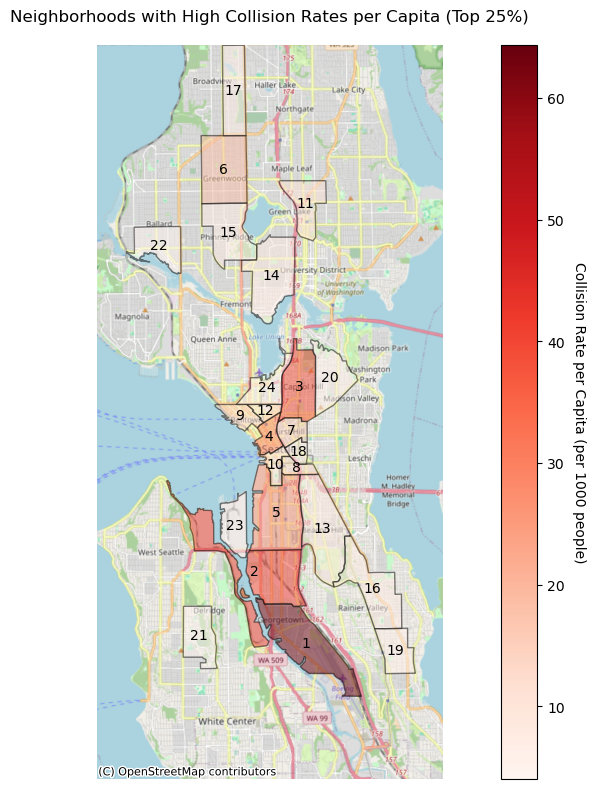

In [254]:
norm = Normalize(vmin=high_collision_rate_gdf['collision_rate_per_capita'].min(), vmax=high_collision_rate_gdf['collision_rate_per_capita'].max())
cmap = plt.cm.Reds

fig, ax = plt.subplots(figsize=(12, 8))

for idx, row in high_collision_rate_gdf.iterrows():
    hood = row[neigh_col]
    geom = row['geometry']
    color = cmap(norm(row['collision_rate_per_capita']))
    gpd.GeoSeries([geom]).plot(ax=ax, color=color, edgecolor='black', linewidth=1, alpha=0.5)

for idx, row in high_collision_rate_gdf.iterrows():
    centroid = row['geometry'].centroid
    ax.text(centroid.x, centroid.y, f"{row['rank']}", fontsize=10, ha='center', va='center', color='black')

sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, label='Collision Rate per Capita (per 1000 people)')
cbar.set_label('Collision Rate per Capita (per 1000 people)', rotation=270, labelpad=15)

ax.set_xlim(micromobility_collisions.total_bounds[0], micromobility_collisions.total_bounds[2])
ax.set_ylim(micromobility_collisions.total_bounds[1], micromobility_collisions.total_bounds[3])
ax.set_axis_off()
plt.title("Neighborhoods with High Collision Rates per Capita (Top 25%)")


ctx.add_basemap(ax, crs=base_crs, source=ctx.providers.OpenStreetMap.Mapnik)

plt.tight_layout()
plt.show()